In [1]:
import keras
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

# Define the EDSRModel class
class EDSRModel(tf.keras.Model):
    # ... (same as in the original code)
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Define ResBlock and Upsampling functions (same as in the original code)
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

# Instantiate the model
model = make_model(num_filters=64, num_of_residual_blocks=16)

# Using the same optimizer setup
optim_edsr = tf.keras.optimizers.legacy.Adam(
    learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

# Compile the model with the same configuration
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

# Load the trained weights into the model
model.load_weights("edsr.keras")

# Now you can use the loaded model for inference
# Example: result = model.predict(input_data)


In [3]:
model.summary()

Model: "edsr_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['rescaling[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                         

In [4]:
image = Image.open("try.jpg")

In [5]:
resized_image = image.resize((150, 150), resample=Image.LANCZOS)

In [6]:
preds = model.predict_step(resized_image)

In [7]:
from matplotlib import pyplot as plt

In [8]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()

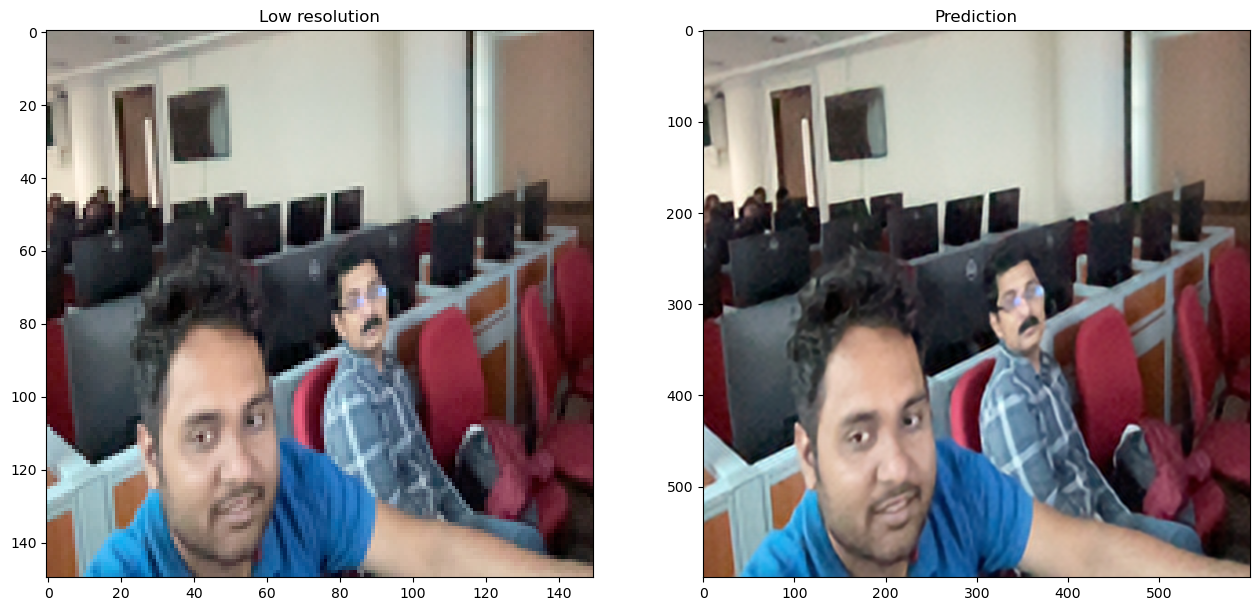

In [9]:
plot_results(resized_image, preds)